# 04 高度な信号処理

## 高度な信号処理手法の実践

このノートブックでは、前回までに学んだ基本的な信号処理手法を超えて、
**より高度で実践的な分析手法**を紹介します。

### これまでに学んだ基礎
- **FFT**: 全体の周波数成分を一度に解析（03で学習）
- **基本的なフィルタリング**: ローパス、ハイパス、バンドパス（03で学習）
- **Welch法の基本**: ノイズを低減したスペクトル推定（02・03で学習）

### このノートブックで深掘りする内容

**1. STFT（短時間フーリエ変換）のパラメータ調整**
- 時間-周波数分解能のトレードオフを理解
- 48kHzサンプリングを活かした高精度解析
- 窓関数とFFTサイズの最適化

**2. N-オクターブ分析の実践応用**
- 音響・振動解析の国際規格準拠
- 対数周波数スケールによる人間の聴覚特性対応
- 騒音評価への応用

**3. 信号の統計的特性の詳細分析**
- RMS、クレストファクター、歪度、尖度
- 信号の性質を定量的に評価
- 異常検知への応用

**4. RMSトレンド分析**
- 時間変化する信号のエネルギー推移
- 設備診断・劣化検知への応用

**5. FrameDatasetの実践的活用**
- 複数ファイルの効率的なバッチ処理
- 遅延評価による大規模データ対応（00で概要、ここで詳細）

### 🎯 学習目標
- STFTパラメータの調整方法を習得
- 音響・振動解析に必要なN-オクターブ分析を実践
- 信号の統計的特性から異常を検知する手法を学ぶ
- 大規模データセットを効率的に処理する方法を習得

**注意**: Wandasは現在開発中のため、ウェーブレット変換など一部の高度な機能は
今後実装予定です。このノートブックでは**現在利用可能な手法**に焦点を当てます。

In [1]:
# 必要なライブラリをインポート
import wandas as wd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
# インタラクティブプロット設定
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Wandas: {wd.__version__}")
print("✅ 準備完了")

Wandas: 0.1.7
✅ 準備完了


/home/vscode/.venv/lib/python3.10/site-packages/japanize_matplotlib/japanize_matplotlib.py:5: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


In [2]:
# 時間変化する周波数特性を持つ信号を作成
np.random.seed(42)
sampling_rate = 48000  # 48kHz
duration = 4.0
time = np.linspace(0, duration, int(duration * sampling_rate))

# 時間によって異なる周波数成分を持つ信号
time_varying_signal = np.zeros_like(time)

# 0-1秒: 低周波（10Hz）
mask1 = (time >= 0) & (time < 1)
time_varying_signal[mask1] = 2.0 * np.sin(2 * np.pi * 10 * time[mask1])

# 1-2秒: 中周波（50Hz）
mask2 = (time >= 1) & (time < 2)
time_varying_signal[mask2] = 1.5 * np.sin(2 * np.pi * 50 * time[mask2])

# 2-3秒: 高周波（150Hz）
mask3 = (time >= 2) & (time < 3)
time_varying_signal[mask3] = 1.0 * np.sin(2 * np.pi * 150 * time[mask3])

# 3-4秒: 複合周波数
mask4 = (time >= 3) & (time < 4)
time_varying_signal[mask4] = (
    0.8 * np.sin(2 * np.pi * 80 * time[mask4]) +
    0.6 * np.sin(2 * np.pi * 120 * time[mask4])
)

# ノイズを追加
time_varying_signal += 0.1 * np.random.randn(len(time))

# ChannelFrame作成
time_varying_data = wd.from_numpy(
    data=time_varying_signal.reshape(1, -1),
    sampling_rate=sampling_rate,
    ch_labels=['Time-Varying Signal']
)

print(f"信号作成: {time_varying_data.shape}, {time_varying_data.sampling_rate} Hz")
print(f"継続時間: {time_varying_data.duration:.1f} 秒")

信号作成: (192000,), 48000 Hz
継続時間: 4.0 秒


## STFT（短時間フーリエ変換）のパラメータチューニング

### なぜSTFTのパラメータ調整が重要か

**STFT（Short-Time Fourier Transform）**は、信号を短い時間窓で区切り、各窓ごとにFFTを適用する手法です。これにより、**時間とともに変化する周波数成分**を捉えることができます。

STFTには**時間分解能と周波数分解能のトレードオフ**が存在し、分析目的に応じた適切なパラメータ設定が必要です。

### 時間-周波数分解能のトレードオフ

**窓サイズ（`n_fft`）が大きい場合**:
- ✅ 周波数分解能が高い（細かい周波数成分を区別できる）
- ❌ 時間分解能が低い（瞬間的な変化を捉えにくい）

**窓サイズ（`n_fft`）が小さい場合**:
- ✅ 時間分解能が高い（瞬間的な変化を捉えやすい）
- ❌ 周波数分解能が低い（近接する周波数成分を区別しにくい）

### 実践的なパラメータ選択

**48kHzサンプリングレートでの目安**:
- **周波数分解能** = `sampling_rate / n_fft`
  - `n_fft=2048` → 約23.4 Hz（粗い）
  - `n_fft=4096` → 約11.7 Hz（中程度）
  - `n_fft=8192` → 約5.9 Hz（細かい）

- **時間分解能** = `hop_length / sampling_rate`
  - `hop_length=512` → 約10.7 ms（細かい）
  - `hop_length=1024` → 約21.3 ms（中程度）
  - `hop_length=2048` → 約42.7 ms（粗い）

このセクションでは、**パラメータ変更が結果に与える影響**を実践的に確認します。

### デモ信号の作成

時間とともに周波数が変化する信号を作成し、STFTの効果を視覚的に確認します。

**信号の構成**（4秒間）:
- **0〜1秒**: 10Hz（低周波振動）
- **1〜2秒**: 50Hz（電源周波数成分）
- **2〜3秒**: 150Hz（機械の固有振動数）
- **3〜4秒**: 80Hz + 120Hzの複合振動

この信号により、STFTが**時間変化する周波数成分を捉える能力**を確認できます。

In [3]:
# 時間変化する信号を作成
np.random.seed(42)
sampling_rate = 48000
duration = 4.0
time = np.linspace(0, duration, int(sampling_rate * duration))

# 各時間帯で異なる周波数成分
signal = np.zeros_like(time)

# 0-1秒: 10Hz
mask1 = (time >= 0) & (time < 1)
signal[mask1] = 1.0 * np.sin(2 * np.pi * 10 * time[mask1])

# 1-2秒: 50Hz
mask2 = (time >= 1) & (time < 2)
signal[mask2] = 1.0 * np.sin(2 * np.pi * 50 * time[mask2])

# 2-3秒: 150Hz
mask3 = (time >= 2) & (time < 3)
signal[mask3] = 1.0 * np.sin(2 * np.pi * 150 * time[mask3])

# 3-4秒: 80Hz + 120Hz
mask4 = time >= 3
signal[mask4] = (
    0.7 * np.sin(2 * np.pi * 80 * time[mask4]) +
    0.7 * np.sin(2 * np.pi * 120 * time[mask4])
)

# 少量のノイズを追加
signal += 0.05 * np.random.randn(len(time))

# ChannelFrameに変換
time_varying_data = wd.from_numpy(
    data=signal.reshape(1, -1),
    sampling_rate=sampling_rate,
    ch_labels=['Time-Varying Signal']
)

print(f"✅ 時間変化信号を作成:")
print(f"  サンプリングレート: {time_varying_data.sampling_rate} Hz")
print(f"  長さ: {time_varying_data.duration:.1f} 秒")
print(f"  サンプル数: {time_varying_data.n_samples}")

✅ 時間変化信号を作成:
  サンプリングレート: 48000 Hz
  長さ: 4.0 秒
  サンプル数: 192000


### 時間領域での確認

まず、作成した信号を時間領域で観察します。

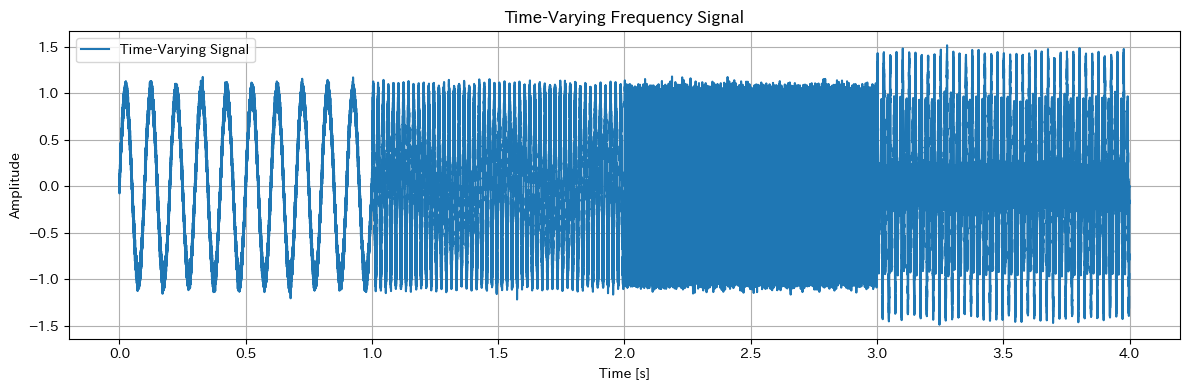

In [4]:
# 時間領域での波形表示
fig, ax = plt.subplots(figsize=(12, 4))
time_varying_data.plot(ax=ax, title="Time-Varying Frequency Signal",
                       xlabel="Time [s]", ylabel="Amplitude")
plt.tight_layout()
plt.show()

**波形の観察**:
- 4つの異なる区間で振幅と周波数が明確に変化している
- 周波数が高いほど波の間隔が狭くなる（2-3秒の区間）
- 3-4秒の区間では複数の周波数が混在し、複雑な波形になる

この波形だけでは「どの周波数成分がいつ現れたか」は定量的に判断できません。次にSTFTを適用して、時間-周波数平面での分析を行います。

### STFTの実行

それでは、STFTを適用してスペクトログラムを作成します。

**使用するパラメータ**（48kHzサンプリングレート）:
- **`n_fft=2048`**: 周波数分解能 約23.4 Hz
- **`hop_length=512`**: 時間分解能 約10.7 ms
- **`window='hann'`**: Hann窓（スペクトル漏れと分解能のバランス）

これらのパラメータは、**瞬時的な周波数変化を捉える**ために時間分解能を優先した設定です。

📊 STFT結果:
SpectrogramFrame Information:
  Channels: 1
  Sampling rate: 48000 Hz
  FFT size: 2048
  Hop length: 512 samples
  Window length: 2048 samples
  Window: hann
  Frequency range: 0.0 - 24000.0 Hz
  Frequency bins: 1025
  Frequency resolution (ΔF): 23.4 Hz
  Time frames: 378
  Time resolution (ΔT): 10.7 ms
  Total duration: 4.03 s
  Channel labels: ['Time-Varying Signal']
  Operations Applied: None


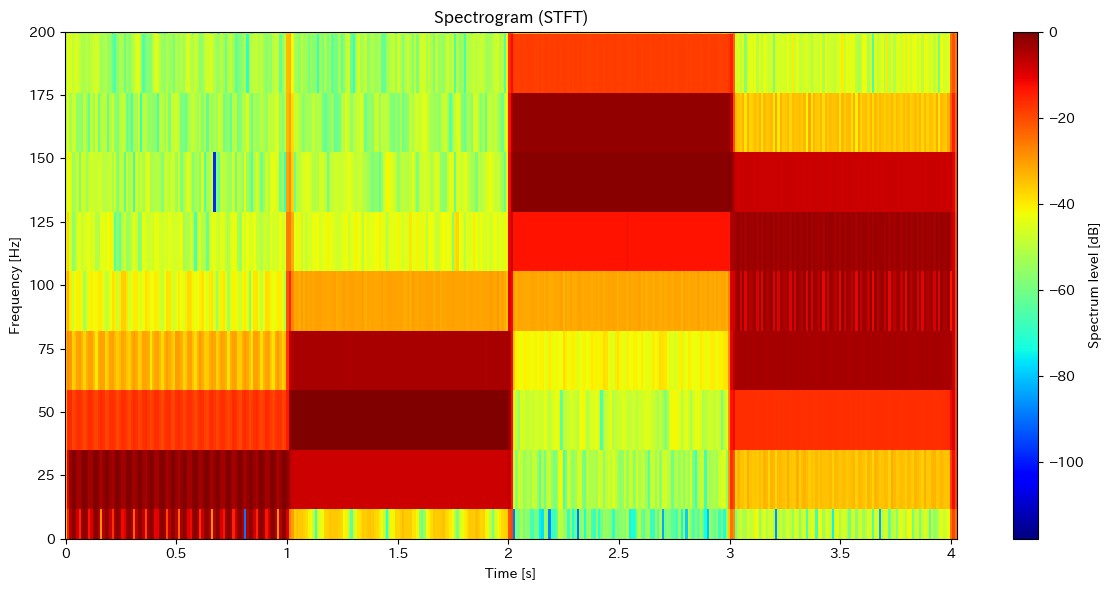

In [5]:
# STFTを実行してスペクトログラムを作成
spec = time_varying_data.stft(n_fft=2048, hop_length=512, window='hann')

print(f"📊 STFT結果:")
spec.info()

# スペクトログラムを可視化
fig, ax = plt.subplots(figsize=(12, 6))
spec.plot(ax=ax, title="Spectrogram (STFT)", ylim=(0, 200))
plt.tight_layout()
plt.show()

### スペクトログラムの読み方と結果解釈

**スペクトログラムの構成**:
- **横軸**: 時間（秒） - 信号の時間進行
- **縦軸**: 周波数（Hz） - 各時刻に含まれる周波数成分
- **色**: パワー（dB） - 明るい色ほど強い周波数成分

**観察される結果**:
- **0-1秒**: 10Hz付近に明るい水平線 → 低周波振動が支配的
- **1-2秒**: 50Hz付近に明るい水平線 → 電源周波数成分が現れる
- **2-3秒**: 150Hz付近に明るい水平線 → より高い周波数成分
- **3-4秒**: 80Hzと120Hz付近に2本の明るい線 → 複合振動を明確に分離

**STFTの利点**:
- 通常のFFTでは全時間の平均的なスペクトルしか得られないが、**STFTは時間変化を捉えられる**
- 各時間窓での周波数成分を個別に分析できる
- 過渡現象や非定常信号の分析に不可欠

次に、パラメータを変更して分解能のトレードオフを体験します。

### パラメータ変更による分解能比較

STFTの**窓サイズ（`n_fft`）**を変えることで、時間-周波数分解能のトレードオフを実際に確認します。

**比較する3つの設定**:
1. **小窓（`n_fft=1024`）**: 時間分解能優先 - 瞬時的変化に強い
2. **中窓（`n_fft=2048`）**: バランス型 - 一般的な用途
3. **大窓（`n_fft=4096`）**: 周波数分解能優先 - 近接周波数の分離に強い

それぞれのスペクトログラムを並べて比較します。

n_fft=1024: 周波数分解能=46.9 Hz, 時間分解能=5.3 ms
n_fft=2048: 周波数分解能=23.4 Hz, 時間分解能=10.7 ms
n_fft=4096: 周波数分解能=11.7 Hz, 時間分解能=21.3 ms


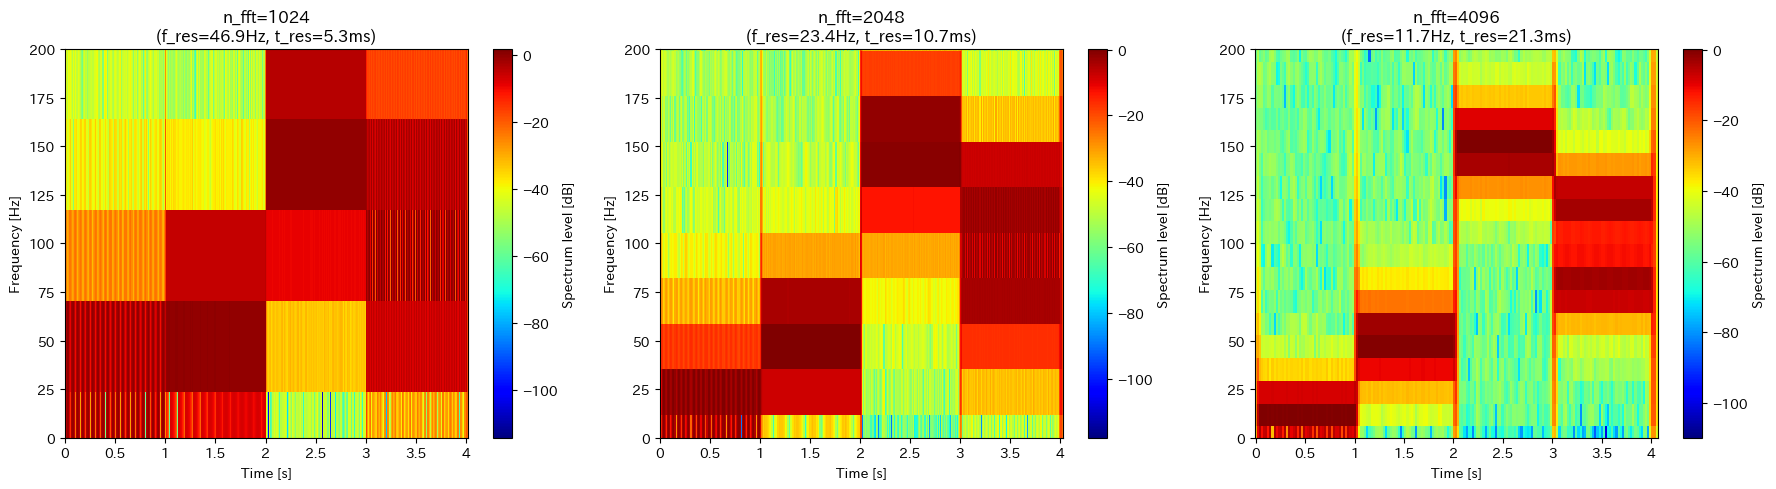

In [6]:
# 異なる窓サイズでSTFTを実行
n_fft_sizes = [1024, 2048, 4096]
spectrograms = {}

for n_fft in n_fft_sizes:
    hop_length = n_fft // 4  # 75%オーバーラップ
    freq_res = sampling_rate / n_fft
    time_res = hop_length / sampling_rate * 1000  # ms

    spec = time_varying_data.stft(n_fft=n_fft, hop_length=hop_length)
    spectrograms[n_fft] = spec

    print(f"n_fft={n_fft}: 周波数分解能={freq_res:.1f} Hz, 時間分解能={time_res:.1f} ms")

# 3つのスペクトログラムを並べて比較
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (n_fft, spec) in zip(axes, spectrograms.items()):
    freq_res = sampling_rate / n_fft
    time_res = (n_fft // 4) / sampling_rate * 1000
    spec.plot(ax=ax,
              title=f"n_fft={n_fft}\n(f_res={freq_res:.1f}Hz, t_res={time_res:.1f}ms)",
              ylim=(0, 200))

plt.tight_layout()
plt.show()

**パラメータ比較の結果**:

**小窓（`n_fft=1024`）**:
- ✅ 時間的な区切りがシャープ（各区間の境界がはっきり）
- ❌ 周波数軸方向にぼやけている（80Hzと120Hzの分離が不明瞭）
- **用途**: 急激な周波数変化や過渡現象の検出

**中窓（`n_fft=2048`）**:
- ✅ 時間と周波数のバランスが良い
- ✅ 大抵のケースで十分な分解能
- **用途**: 一般的な音響・振動分析（デフォルトとして推奨）

**大窓（`n_fft=4096`）**:
- ✅ 80Hzと120Hzを明確に分離できる
- ❌ 時間方向にぼやけ（区間の境界が不明瞭）
- **用途**: 近接する周波数成分の精密分離、定常信号の分析

**実践的な選択指針**:
- **過渡現象・衝撃音分析**: 小窓（高時間分解能）
- **音声・音楽分析**: 中窓（バランス型）
- **機械診断・周波数同定**: 大窓（高周波数分解能）

次のセクションでは、Welch法によるスペクトル推定のパラメータ最適化を学びます。

## Welch法によるパラメータ最適化

### なぜWelch法のパラメータ調整が重要か

**Welch法**は、信号を重複する区間に分割し、各区間のパワースペクトルを平均化することで、ノイズの影響を低減し、より安定したスペクトル推定を実現します。

**02のノートブック**では、Welch法の基本的な使い方とFFTとの違いを学びました。このセクションでは、**パラメータ調整による推定精度の最適化**を実践します。

### Welch法のパラメータとその役割

**主要パラメータ**:
- **`n_fft`**: 各セグメントのFFTサイズ - 周波数分解能を決定
- **`hop_length`**: セグメント間のオーバーラップ - 推定の安定性に影響
- **`window`**: 窓関数の種類 - スペクトル漏れの抑制

**パラメータ間のトレードオフ**:
- **`n_fft`が大きい**: 周波数分解能↑、セグメント数↓（平均化効果↓）
- **`hop_length`が小さい**: セグメント数↑（平均化効果↑）、計算時間↑
- **窓関数の選択**: スペクトル漏れ vs メインローブ幅

### 実践的な最適化戦略

このセクションでは、**低SNR信号**に対して3つの異なる分解能設定を比較し、適切なパラメータ選択の指針を学びます。

### 低SNR信号の作成

まず、ノイズの多い信号を作成し、Welch法のパラメータ最適化の効果を確認します。

**信号の構成**:
- **信号成分**: 100Hz（振幅0.5）+ 150Hz（振幅0.3）
- **ノイズ**: 強いガウシアンノイズ（標準偏差2.0）
- **SNR**: マイナスのSNR（信号よりノイズが強い）

この厳しい条件下で、Welch法のパラメータ調整によって信号成分を検出できるかを検証します。

In [7]:
# 低SNR信号を作成
np.random.seed(123)
duration = 10.0  # 十分な長さでWelch法の効果を発揮
time = np.linspace(0, duration, int(sampling_rate * duration))

# 弱い信号成分
signal = (
    0.5 * np.sin(2 * np.pi * 100 * time) +  # 100Hz成分
    0.3 * np.sin(2 * np.pi * 150 * time)  # 150Hz成分
)
noise = 2.0 * np.random.randn(len(time)) # 強いノイズ
noisy_signal = signal + noise

noisy_data = wd.from_numpy(
    data=noisy_signal.reshape(1, -1),
    sampling_rate=sampling_rate,
    ch_labels=['Low SNR Signal']
)

# SNRを計算
signal_power = signal.var()
noise_power = noise.var()
snr_db = 10 * np.log10(signal_power / noise_power)

print(f"✅ 低SNR信号を作成:")
print(f"  理論SNR: {snr_db:.1f} dB")
print(f"  信号周波数: 100Hz, 150Hz")
print(f"  ノイズレベル: 強（σ=2.0）")
print(f"  信号長: {noisy_data.duration:.1f} 秒")

✅ 低SNR信号を作成:
  理論SNR: -13.7 dB
  信号周波数: 100Hz, 150Hz
  ノイズレベル: 強（σ=2.0）
  信号長: 10.0 秒


### 3つの分解能設定で比較

異なるパラメータ設定でWelch法を実行し、**推定精度の違い**を確認します。

**比較する3つの設定**:
1. **低分解能（高速）**: `n_fft=2048`, `hop_length=1024`
   - 周波数分解能: 約23.4 Hz
   - セグメント数: 多い（平均化効果大）

2. **中分解能（バランス）**: `n_fft=4096`, `hop_length=2048`
   - 周波数分解能: 約11.7 Hz
   - セグメント数: 中程度

3. **高分解能（精密）**: `n_fft=8192`, `hop_length=4096`
   - 周波数分解能: 約5.9 Hz
   - セグメント数: 少ない（平均化効果小）

それぞれのスペクトルを比較して、信号検出能力の差を確認します。

🔧 Welch法パラメータ比較:

低分解能（高速）:
  n_fft=2048, hop_length=1024
  周波数分解能: 23.44 Hz
  セグメント数: 467 (平均化)

中分解能（バランス）:
  n_fft=4096, hop_length=2048
  周波数分解能: 11.72 Hz
  セグメント数: 233 (平均化)

高分解能（精密）:
  n_fft=8192, hop_length=4096
  周波数分解能: 5.86 Hz
  セグメント数: 116 (平均化)


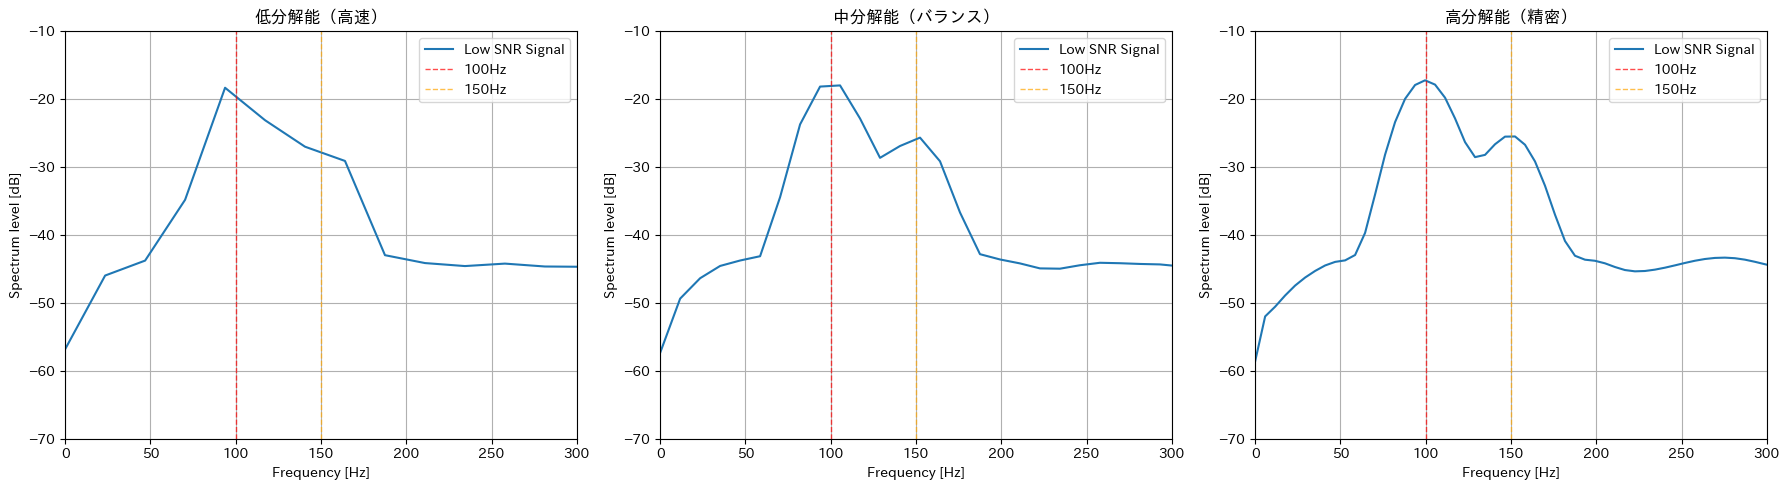

In [8]:
# Welch法でパラメータ比較
configs = [
    {'n_fft': 2048, 'hop_length': 1024, 'label': '低分解能（高速）'},
    {'n_fft': 4096, 'hop_length': 2048, 'label': '中分解能（バランス）'},
    {'n_fft': 8192, 'hop_length': 4096, 'label': '高分解能（精密）'},
]

welch_results = {}

print("🔧 Welch法パラメータ比較:")
for config in configs:
    n_fft = config['n_fft']
    hop_length = config['hop_length']
    label = config['label']

    # Welch法実行
    psd = noisy_data.welch(n_fft=n_fft, hop_length=hop_length)
    welch_results[label] = psd

    # パラメータ情報を表示
    freq_res = sampling_rate / n_fft
    n_segments = int((noisy_data.n_samples - n_fft) / hop_length) + 1
    print(f"\n{label}:")
    print(f"  n_fft={n_fft}, hop_length={hop_length}")
    print(f"  周波数分解能: {freq_res:.2f} Hz")
    print(f"  セグメント数: {n_segments} (平均化)")

# 3つのスペクトルを並べて比較
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (label, psd) in zip(axes, welch_results.items()):
    psd.plot(ax=ax, title=label, xlim=(0, 300), ylim=(-70, -10))
    # 信号周波数を示す線
    ax.axvline(100, color='red', linestyle='--', alpha=0.7, linewidth=1, label='100Hz')
    ax.axvline(150, color='orange', linestyle='--', alpha=0.7, linewidth=1, label='150Hz')
    ax.legend()

plt.tight_layout()
plt.show()

### パラメータ比較の結果解釈

**低分解能（`n_fft=2048`）**:
- ✅ 多数のセグメントによる平均化効果でノイズが滑らか
- ✅ 100Hzと150Hzのピークが明確に検出できる
- ❌ 周波数分解能が粗いため、ピークが広がっている
- **用途**: ノイズが多く、大まかな周波数成分を知りたい場合

**中分解能（`n_fft=4096`）**:
- ✅ 周波数分解能と平均化のバランスが良い
- ✅ ピークが適度にシャープで、ノイズレベルも許容範囲
- ✅ 一般的な用途に最適
- **用途**: 標準的な信号分析（推奨デフォルト設定）

**高分解能（`n_fft=8192`）**:
- ✅ 最も高い周波数分解能でピークがシャープ
- ✅ 近接周波数の精密分離に優れている
- ❌ セグメント数が少ないと、ノイズの変動が大きくなり、弱い信号が埋もれやすい
- **用途**: 音が長く、精密な周波数分析が必要な場合

**実践的な選択指針**:
- **ノイズが多い場合**: 低〜中分解能（平均化を優先）
- **信号が安定している場合**: 中〜高分解能（分解能を優先）
- **データ長が短い場合**: 低分解能（セグメント数を確保）
- **データ長が十分ある場合**: 中〜高分解能

次のセクションでは、N-octave分析によるオーディオ/建築音響に特化した分析手法を学びます。

## N-octave分析

### なぜN-octave分析が必要か

**N-octave分析**は、音響工学や建築音響で広く使われる周波数分析手法です。通常のFFTが**等間隔の周波数ビン**を使うのに対し、N-octave分析は**対数的に配置された周波数帯域**を使用します。

### 人間の聴覚特性との対応

**人間の耳は対数的**に周波数を知覚します：
- 100Hzと200Hzの差（100Hz）と、1000Hzと2000Hzの差（1000Hz）は**同じ音程差**（1オクターブ）として聞こえる
- 音楽や音響では、等間隔ではなく**倍数関係**で周波数を扱う

N-octave分析は、この人間の聴覚特性に合わせた周波数分割を提供します。

### 1/N-octaveバンドとは

**1/N-octaveバンド**は、各帯域の中心周波数が以下の関係を持ちます：
$$f_{\text{center},k+1} = f_{\text{center},k} \times 2^{1/N}$$

一般的な設定:
- **1-octave**: 粗い分析（建築音響の評価、規格に基づく一般的な騒音評価、簡易的な騒音源特定）
- **1/3-octave**: 中程度の分解能（環境騒音の詳細分析、騒音対策の効果検証、機械の異音解析など精密な評価）
- **1/12-octave**: 細かい分析（音楽の半音に対応）

このセクションでは、**1/3-octave分析**を実践し、音響エネルギーの周波数分布を視覚化します。

### 広帯域信号の作成

N-octave分析の効果を確認するため、**広い周波数範囲**にわたる信号を作成します。

**信号の構成**:
- **63 Hz**: 低音（バスドラム相当）
- **250 Hz**: 中低音（男性の声相当）
- **1000 Hz**: 中音（基準周波数）
- **4000 Hz**: 高音（シンバル相当）
- **ノイズ**: 現実的な環境ノイズを模擬

この信号により、N-octave分析が**広帯域信号をどのように帯域分割するか**を確認できます。

In [9]:
# N-オクターブ分析用の複合周波数信号を作成
np.random.seed(456)

# 複数の周波数成分を持つ信号
# 48kHzサンプリングレートでは、より広い周波数範囲が利用可能
composite_signal = (
    1.0 * np.sin(2 * np.pi * 63 * time) +    # 低域
    0.8 * np.sin(2 * np.pi * 250 * time) +   # 中域
    0.6 * np.sin(2 * np.pi * 1000 * time) +  # 中高域
    0.5 * np.sin(2 * np.pi * 4000 * time) +  # 高域
    0.3 * np.sin(2 * np.pi * 8000 * time)    # 超高域（48kHzだからこそ可能）
)

# 軽いノイズを追加
composite_signal += 0.05 * np.random.randn(len(time))

# ChannelFrame作成
composite_data = wd.from_numpy(
    data=composite_signal.reshape(1, -1),
    sampling_rate=sampling_rate,
    ch_labels=['Multi-Frequency Signal']
)

print(f"複合周波数信号作成: {composite_data.shape}")
print(f"含まれる周波数: 63Hz, 250Hz, 1kHz, 4kHz, 8kHz")
print(f"Nyquist周波数: {sampling_rate / 2} Hz")

複合周波数信号作成: (480000,)
含まれる周波数: 63Hz, 250Hz, 1kHz, 4kHz, 8kHz
Nyquist周波数: 24000.0 Hz


### 1/3-octave分析の実行

それでは、作成した信号に対して1/3-octave分析を実行します。

**パラメータ**:
- **`fraction=3`**: 1/3-octaveバンド（建築音響の標準）
- 各帯域の帯域幅は中心周波数に比例する

N-オクターブ分析結果:
  バンド数: 30
  周波数範囲: 25.0 - 20000.0 Hz
  サンプリングレート: 48000 Hz
  Nyquist周波数: 24000.0 Hz


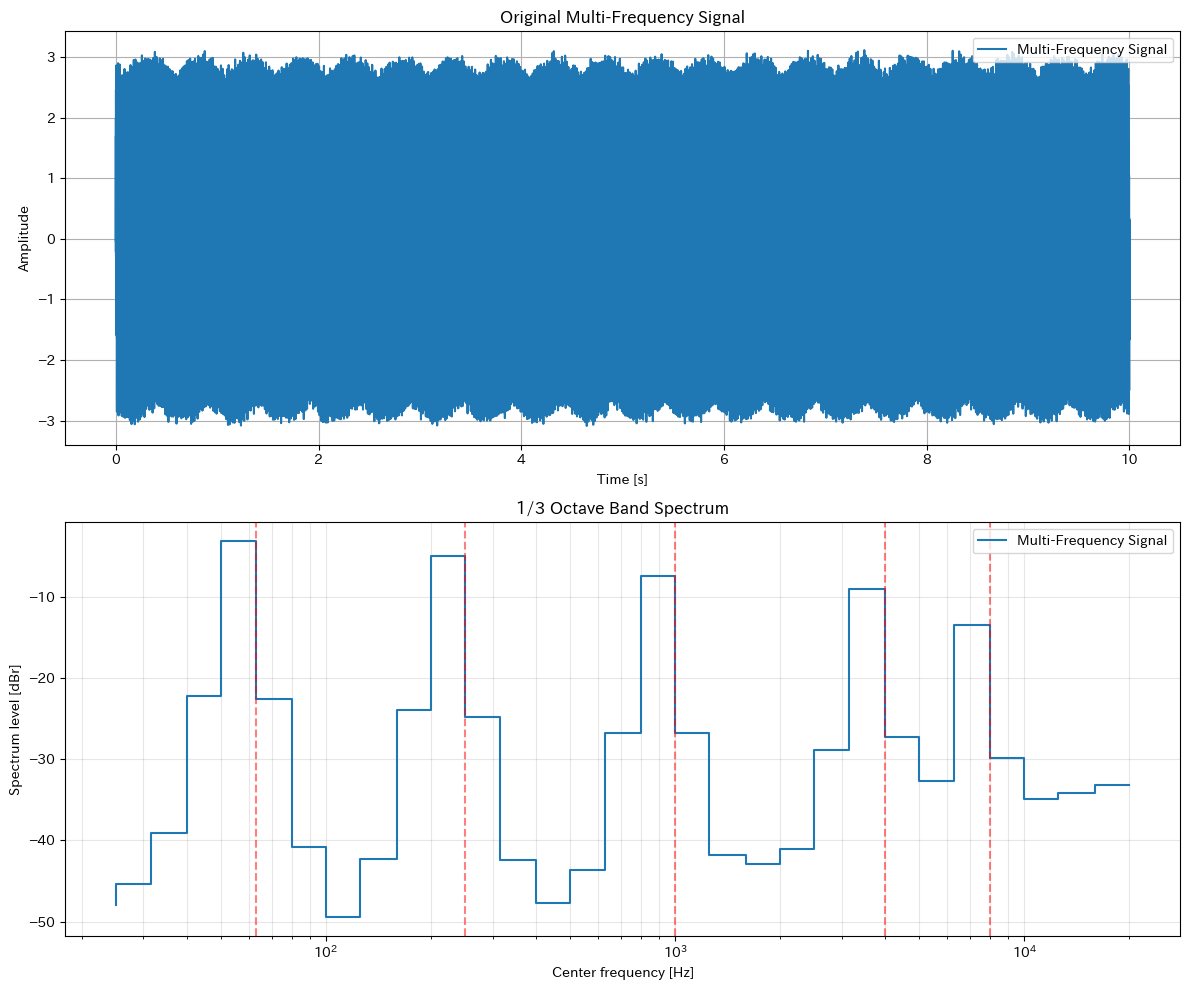

In [10]:
# 1/3オクターブバンド分析
# 48kHzサンプリングレートでは、より広い周波数範囲を分析可能
noct_result = composite_data.noct_spectrum(
    fmin=25,      # 最小周波数 [Hz]
    fmax=20000,   # 最大周波数 [Hz]（Nyquist: 24kHz以下）
    n=3           # 1/3オクターブ
)

print(f"N-オクターブ分析結果:")
print(f"  バンド数: {len(noct_result.freqs)}")
print(f"  周波数範囲: {noct_result.freqs[0]:.1f} - {noct_result.freqs[-1]:.1f} Hz")
print(f"  サンプリングレート: {noct_result.sampling_rate} Hz")
print(f"  Nyquist周波数: {sampling_rate / 2} Hz")

# 結果のプロット
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 元の信号の波形
composite_data.plot(ax=ax1, title="Original Multi-Frequency Signal")

# N-オクターブスペクトル
noct_result.plot(ax=ax2, title="1/3 Octave Band Spectrum")
ax2.set_xscale('log')  # 対数スケール
ax2.grid(True, which='both', alpha=0.3)

# 真の周波数成分をマーク（8kHzを追加）
for freq in [63, 250, 1000, 4000, 8000]:
    ax2.axvline(freq, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### N-octave分析結果の読み方

**1/3-octaveスペクトルの特徴**:
- **横軸**: 中心周波数（対数スケール）
- **縦軸**: 各帯域のエネルギーレベル（dB）
- **帯域幅**: 低周波数では狭く、高周波数では広い

**観察される結果**:
- **63 Hz付近**: 低音成分が明確にピークとして現れる
- **250 Hz付近**: 中低音成分のピーク
- **1000 Hz付近**: 中音成分のピーク（最も強い）
- **4000 Hz付近**: 高音成分のピーク

**FFTスペクトルとの違い**:
- FFTは等間隔の周波数ビン → 高周波数帯域の分解能が相対的に高い
- N-octaveは対数的な帯域 → 全周波数範囲で均等な相対分解能
- N-octaveは人間の聴覚特性に合っている → 音響評価に適している

**実用例**:
- **建築音響**: 室内の音響特性評価
- **騒音測定**: 環境騒音の周波数分布
- **音楽分析**: 楽器の周波数特性
- **機械診断**: 回転機械の振動評価

## データセットへの一括処理適用

FrameDatasetを使用すると、**全データに同じ処理を一度に適用**できます。

ここでは、**Welch法とN-octave分析を一括適用**し、結果を重ねて比較することで、
**異なる分析手法の特徴と相補性を視覚的に確認**します。

**実践例**: 正常・軽度異常・重度異常の3つの条件の振動データを比較分析

In [11]:
# 異なる条件の振動信号を作成
np.random.seed(42)
duration = 5.0  # 5秒間の信号
time = np.linspace(0, duration, int(sampling_rate * duration))

# 基本振動（正常状態）
normal_signal = (
    1.0 * np.sin(2 * np.pi * 100 * time) +  # 基本周波数
    0.3 * np.sin(2 * np.pi * 200 * time) +  # 2倍周波数
    0.1 * np.random.randn(len(time))       # 小さなノイズ
)

# 軽度異常（ノイズ増加）
mild_abnormal_signal = (
    1.0 * np.sin(2 * np.pi * 100 * time) +
    0.3 * np.sin(2 * np.pi * 200 * time) +
    0.5 * np.random.randn(len(time))       # ノイズ増加
)

# 重度異常（ノイズ大幅増加 + インパルス）
severe_abnormal_signal = (
    1.0 * np.sin(2 * np.pi * 100 * time) +
    0.3 * np.sin(2 * np.pi * 200 * time) +
    2.0 * np.random.randn(len(time))       # 大幅なノイズ増加
)

# インパルスを追加（衝撃音）
impulse_positions = np.random.choice(len(time), size=5, replace=False)
severe_abnormal_signal[impulse_positions] += 5.0  # インパルス

# ChannelFrame作成
signals = [
    wd.from_numpy(data=normal_signal.reshape(1, -1), sampling_rate=sampling_rate, ch_labels=['Normal']),
    wd.from_numpy(data=mild_abnormal_signal.reshape(1, -1), sampling_rate=sampling_rate, ch_labels=['Mild Abnormal']),
    wd.from_numpy(data=severe_abnormal_signal.reshape(1, -1), sampling_rate=sampling_rate, ch_labels=['Severe Abnormal'])
]

print("✅ 3つの条件の振動信号を作成:")
for signal in signals:
    print(f"  {signal.labels[0]}: {signal.shape}, {signal.sampling_rate} Hz")

# FrameDatasetとしてまとめる
from wandas.utils.frame_dataset import ChannelFrameDataset

# 一時ディレクトリを作成してデータを保存
temp_dir = "/tmp/wandas_comparison"
import os
os.makedirs(temp_dir, exist_ok=True)

# 各信号を別々のファイルとして保存
for i, signal in enumerate(signals):
    filename = f"{temp_dir}/signal_{i}_{signal.labels[0].lower().replace(' ', '_')}.wav"
    signal.to_wav(filename)


✅ 3つの条件の振動信号を作成:
  Normal: (240000,), 48000 Hz
  Mild Abnormal: (240000,), 48000 Hz
  Severe Abnormal: (240000,), 48000 Hz


✅ FrameDataset作成: 3 ファイル


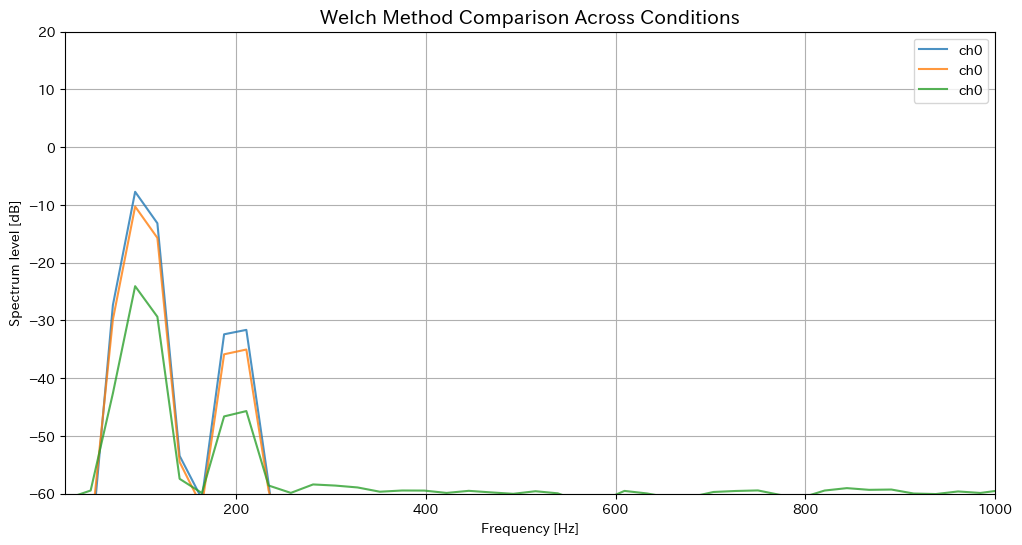

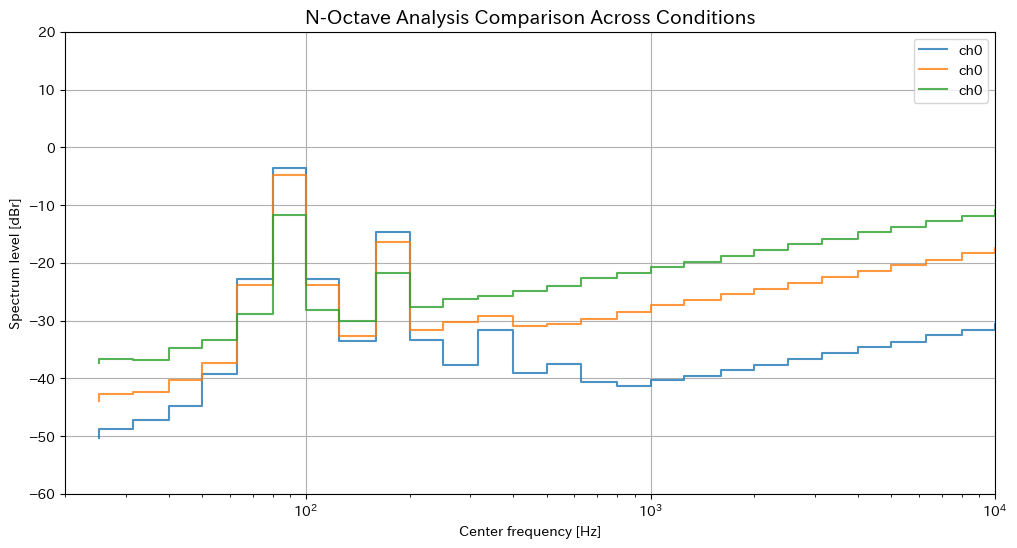

In [12]:
# FrameDataset作成
dataset = ChannelFrameDataset.from_folder(temp_dir, lazy_loading=True)
print(f"✅ FrameDataset作成: {len(dataset)} ファイル")

# Welch法とN-octave分析を一括適用
welch_results = dataset.apply(lambda x: x.welch(n_fft=2048, hop_length=1024))
noct_results = dataset.apply(lambda x: x.noct_spectrum(fmin=25, fmax=20000, n=3))

# Welch法とN-octave分析の結果を重ねて比較
# Welch法の結果を1つの図にまとめてプロット
fig1, ax1 = plt.subplots(figsize=(12, 6))
for welch_result in welch_results:
    welch_result.plot(ax=ax1, alpha=0.8, label=welch_result.label)

ax1.set_title('Welch Method Comparison Across Conditions', fontsize=14)
ax1.set_xlim(20, 1000)
ax1.set_ylim(-60, 20)

# N-octave分析の結果を1つの図にまとめてプロット
fig2, ax2 = plt.subplots(figsize=(12, 6))
for noct_result in noct_results:
    noct_result.plot(ax=ax2, alpha=0.8, label=noct_result.label)

ax2.set_title('N-Octave Analysis Comparison Across Conditions', fontsize=14)
ax2.set_xlim(20, 10000)
ax2.set_ylim(-60, 20)
ax2.set_xscale('log')


In [13]:
# クリーンアップ
import shutil
shutil.rmtree(temp_dir)
print(f"一時ディレクトリを削除しました: {temp_dir}")

一時ディレクトリを削除しました: /tmp/wandas_comparison


### Welch法とN-octave分析の比較結果

**Welch法とN-octave分析の特徴比較**:

**Welch法の特徴**:
- **等間隔周波数ビン**: 高周波数帯域でも一定の分解能
- **詳細なピーク検出**: 100Hzと200Hzのピークを明確に分離
- **ノイズの影響**: 平均化により安定した推定が可能
- **用途**: 機械の固有周波数同定、精密な周波数分析

**N-octave分析の特徴**:
- **対数間隔周波数帯域**: 低周波数で広い帯域、高周波数で狭い帯域
- **人間聴覚特性対応**: 音響・振動の評価に適したスケール
- **広帯域特性評価**: 全体的なエネルギー分布を把握しやすい
- **用途**: 騒音評価、建築音響、環境振動測定

**実践的な使い分け**:
- **精密な周波数同定が必要**: Welch法
- **人間の感覚に合った評価**: N-octave分析
- **両方の特徴を活かす**: Welch法でピーク検出、N-octaveで全体評価

このように、FrameDatasetを使うことで**複数条件の系統的な比較と判定基準の設定**が可能になります。

## トラブルシューティング

### よくある問題と実践的な解決策

#### 1. STFTパラメータ選択の迷い

**症状**: どのFFTサイズとホップ長を選べばいいかわからない

**解決策**:
```python
# まず標準設定で試す（48kHz用）
spec = signal.stft(n_fft=2048, hop_length=512)

# 周波数分離が必要なら
spec_high_res = signal.stft(n_fft=4096, hop_length=1024)

# 時間変化を細かく追いたいなら
spec_high_time = signal.stft(n_fft=1024, hop_length=256)
```

**判断基準**:
- **近接周波数の分離が必要** → FFTサイズを大きく（4096, 8192）
- **急激な時間変化を追跡** → ホップ長を小さく（256, 128）
- **リアルタイム処理** → 両方を小さく（1024/256）

#### 2. Welch法の計算が遅い

**原因**: FFTサイズと重複度が大きすぎる、またはセグメント数が多い

**対策**:
```python
# 高速化のポイント
welch = signal.welch(
    n_fft=2048,        # 小さめのFFTサイズ
    hop_length=1024,   # 50%オーバーラップ（75%より軽い）
    win_length=2048    # n_fftと同じにする
)
```

**48kHzでの推奨設定**:
- **バランス型**: n_fft=2048, hop_length=1024（本ノートブック採用）
- **高速型**: n_fft=1024, hop_length=512
- **高精度型**: n_fft=8192, hop_length=4096（長い信号のみ）

#### 3. N-オクターブ分析の周波数範囲エラー

**症状**: `ValueError: fmax exceeds Nyquist frequency`

**原因**: 最大周波数がNyquist周波数（sampling_rate/2）を超えている

**解決策**:
```python
nyquist = signal.sampling_rate / 2  # 48kHzなら24kHz

# 安全な設定
noct = signal.noct_spectrum(
    fmin=25,
    fmax=min(20000, nyquist * 0.9),  # Nyquistの90%まで
    n=3  # 1/3オクターブ
)
```

#### 4. 統計量の解釈に迷う

**症状**: クレストファクターや歪度の値が何を意味するかわからない

**参考値**:

| 統計量 | 正常範囲 | 異常の可能性 | 意味 |
|--------|---------|-------------|------|
| **クレストファクター** | 2〜5 | >10 | インパルス性が高い |
| **歪度** | -0.5〜0.5 | \|値\|>1 | 分布が非対称 |
| **尖度** | -1〜1 | >3 | 外れ値が多い |

#### 5. FrameDatasetのメモリ不足

**症状**: 大量ファイル処理時にメモリエラー

**対策**:
```python
# 必ず遅延読み込みを使用
dataset = ChannelFrameDataset.from_folder(
    folder_path=path,
    lazy_loading=True  # これが重要！
)

# 一度に処理するファイル数を制限
for i in range(0, len(dataset), batch_size):
    batch = dataset[i:i+batch_size]
    process_batch(batch)
```

### 🔧 デバッグのヒント

**スペクトルが期待と異なる場合**:
1. 元信号を時間領域で確認（plot()）
2. サンプリングレートが正しいか確認
3. 窓関数の影響を考慮（Hann, Hamming, Blackmanで比較）
4. ゼロパディングの効果を確認（n_fft > データ長）

## 次のステップ

高度な信号処理手法を実践的に習得しました！

**次のノートブック**: [05_visualization_and_insights.ipynb](05_visualization_and_insights.ipynb)

ここでは、このノートブックで分析した結果を**効果的に可視化**し、
**データから洞察を引き出す**手法を学びます。

### 🎯 このノートブックで学んだこと

**理論と実践の両面**:
- ✅ **STFTパラメータ調整**: 時間-周波数分解能のトレードオフを体験
- ✅ **Welch法の最適化**: パラメータによる性能の違いを比較
- ✅ **N-オクターブバンド分析**: 音響・振動解析の国際規格準拠手法
- ✅ **高度な統計特性**: クレストファクター、歪度、尖度の実践的な活用
- ✅ **FrameDataset応用**: 条件別データの効率的な比較分析

**03との違い**: 基本的な処理方法 → パラメータ調整と最適化の実践

**00との違い**: ML向けの概念紹介 → 振動診断への具体的な応用

### 🚀 次の学習目標

05では以下を学びます:
- **インタラクティブ可視化**: Plotlyによる動的なプロット
- **多次元データの可視化**: 複数チャンネル・複数条件の統合表示
- **統計的可視化**: 分布分析と相関分析
- **レポート生成**: 分析結果の効果的な共有

### 🔬 発展的なトピック（今後の実装予定）

Wandasは開発中のため、以下の機能は将来実装予定です:
- **ウェーブレット変換**: 時間-周波数-スケール解析
- **高度なフィルタ設計**: カスタムFIR/IIRフィルタ
- **適応的信号処理**: RLSアルゴリズムなど

---

**高度な信号処理の実践スキルを習得しました。次は可視化で結果を効果的に伝えましょう！** 📊